In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn

In [2]:
data_dir = '/Users/jyontika/Desktop/Python/Hughes Lab - DIAMONDS/Opioid-Project/files/'
csv_path = os.path.join(data_dir, 'cook-county-opioid.csv')
d = pd.read_csv(csv_path)

## Working with dates

In [3]:
d["DEATH_DATE"] = pd.to_datetime(d["DEATH_DATE"])

In [4]:
d["DEATH_DATE"].dt.date.min()
d["DEATH_DATE"].dt.date.max()

datetime.date(2023, 6, 17)

In [5]:
#write a function to get nonparsable dates

from dateutil.parser import parse

def get_non_parsable_dates(d, column):
    non_parsable_dates = []
    for date_value in d[column]:
        try:
            pd.to_datetime(str(date_value))
        except ValueError:
            non_parsable_dates.append(date_value)
    return non_parsable_dates

In [6]:
non_parsable_dates = get_non_parsable_dates(d, "INCIDENT_DATE")
d = d[~d['INCIDENT_DATE'].isin(non_parsable_dates)].reset_index(drop=True)
d["INCIDENT_DATE"] = pd.to_datetime(d["INCIDENT_DATE"])

In [7]:
def get_non_date_values(d, column_name):
    non_date_values = d[column_name].loc[
        ~d[column_name].apply(lambda x: isinstance(x, pd.Timestamp))
    ]
    return list(non_date_values)

In [8]:
non_date_values = get_non_date_values(d, 'INCIDENT_DATE')
len(non_date_values) #we have 124 NaT values

124

In [9]:
# Calculate the time difference between death and incident and create a new column
d['Time_Difference'] = d['DEATH_DATE'] - d['INCIDENT_DATE']
d['Time_Difference']

0        0 days 10:10:00
1        0 days 00:30:00
2        0 days 14:30:00
3        0 days 01:40:00
4        0 days 00:54:00
              ...       
12086    3 days 17:48:00
12087    1 days 23:46:00
12088    4 days 19:32:00
12089    1 days 11:05:00
12090   12 days 19:11:00
Name: Time_Difference, Length: 12091, dtype: timedelta64[ns]

In [10]:
arr = np.percentile(d['Time_Difference'], [10,50,90, 95])

In [11]:
arr.astype('timedelta64[s]').astype("int64")/3600

array([-2.56204779e+15, -2.56204779e+15, -2.56204779e+15, -2.56204779e+15])

## Download Census Tract Information

In [12]:
import geopandas as gpd
from shapely.geometry import Point

# Load census tract shapefile
me_shape_path = os.path.join(data_dir, 'ME_Cook/Medical_Examiner_Case_Archive%2C_2014_to_present.shp')
tl_shape_path = os.path.join(data_dir, 'tl_2021_17_tract/tl_2021_17_tract.shp')

me_gdf = gpd.read_file(me_shape_path)
tl_gdf = gpd.read_file(tl_shape_path)

me_gdf.to_crs(tl_gdf.crs, inplace=True)

<Axes: >

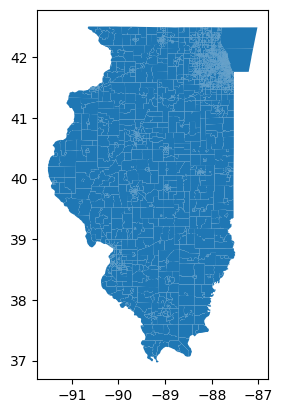

In [13]:
tl_gdf.plot()


In [14]:
tl_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,047,957100,17047957100,9571,Census Tract 9571,G5020,S,17502924,151254,+38.3810609,-088.0566832,"POLYGON ((-88.10244 38.39351, -88.10232 38.393..."
1,17,047,956900,17047956900,9569,Census Tract 9569,G5020,S,289722767,430838,+38.4939617,-088.0440563,"POLYGON ((-88.14857 38.46782, -88.14856 38.468..."
2,17,167,003901,17167003901,39.01,Census Tract 39.01,G5020,S,107283391,1202385,+39.6960595,-089.5296888,"POLYGON ((-89.59191 39.69246, -89.59116 39.692..."
3,17,167,003500,17167003500,35,Census Tract 35,G5020,S,548131091,280907,+39.7333761,-089.8871664,"POLYGON ((-89.99450 39.89447, -89.99451 39.897..."
4,17,167,003802,17167003802,38.02,Census Tract 38.02,G5020,S,71333933,955509,+39.8488280,-089.5115697,"POLYGON ((-89.56791 39.87580, -89.56739 39.875..."


In [15]:
tl_gdf[tl_gdf['COUNTYFP']=='031'].shape #1332 unique counties

(1332, 13)

In [16]:
me_gdf = me_gdf.dropna(subset=['geometry']) #drop people with missing Geometry values (lat, long)

In [17]:
#kyle's code

tl_gdf['deaths'] = 0
missing_geo = 0
for i, death in me_gdf.iterrows():
    
    if death.geometry is None:
        missing_geo +=1
        continue
    
    containing_tract_idx = tl_gdf.contains(death.geometry)
    assert(containing_tract_idx.sum()==1)
    tl_gdf.loc[containing_tract_idx, 'deaths'] += 1

<Axes: >

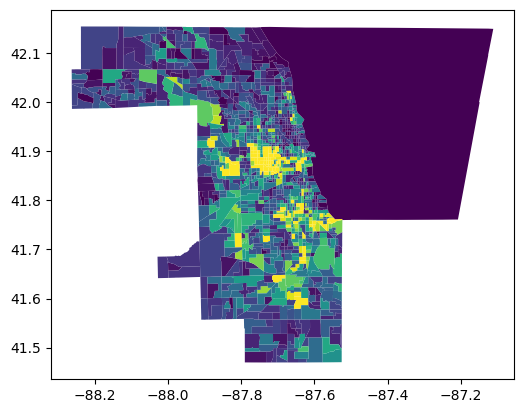

In [18]:
tl_gdf[tl_gdf['COUNTYFP']=='031'].plot('deaths',vmax=20)

In [19]:
cook_county_tracts = tl_gdf[tl_gdf['COUNTYFP'] == '031']

# spatial join between the deaths GeoDataFrame and the filtered cook_county_tracts
cook_county_gdf = gpd.sjoin(me_gdf, cook_county_tracts, how='left', predicate='within')

In [20]:
cook_county_gdf.shape

(11179, 47)

In [21]:
# find the tracts that exist but have no deaths (and need to be added to dataframe)
CC_nodeaths = tl_gdf[(tl_gdf['COUNTYFP'] == '031') & (tl_gdf['deaths'] == 0)]

len(CC_nodeaths)

58

In [22]:
cook_county_gdf['GEOID'].nunique() #1274 + 58 = 1332 unique tracts

1274

In [23]:
cook_county_gdf.dropna(subset=['GEOID'], inplace=True)
cook_county_gdf["DEATH_DATE"] = pd.to_datetime(cook_county_gdf["DEATH_DATE"])
cook_county_gdf['year'] = cook_county_gdf['DEATH_DATE'].dt.year
cook_county_gdf['quarter'] = cook_county_gdf['DEATH_DATE'].dt.quarter
cook_county_gdf['semiannual'] = cook_county_gdf['DEATH_DATE'].dt.quarter.apply(lambda x: 1 if x <= 2 else 2)


In [24]:
cook_county_gdf.columns

Index(['CASENUMBER', 'INCIDENT_D', 'DEATH_DATE', 'AGE', 'GENDER', 'RACE',
       'LATINO', 'MANNER', 'PRIMARYCAU', 'PRIMARYC_1', 'PRIMARYC_2',
       'PRIMARYC_3', 'SECONDARYC', 'COLD_RELAT', 'HEAT_RELAT', 'INCIDENT_S',
       'INCIDENT_C', 'INCIDENT_Z', 'RESIDENCE_', 'RESIDENC_1', 'CommDistri',
       'AGE_GROUP', 'OPIOID_REL', 'GUN_RELATE', 'chi_ward', 'chi_commar',
       'last_edite', 'OBJECTID', 'longitude', 'latitude', 'COVID_RELA',
       'Shape', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'deaths', 'year', 'quarter', 'semiannual'],
      dtype='object')

In [25]:
#subset columns that are relevant on non-individual level basis
cook_county_gdf_year = cook_county_gdf.loc[:, ['year', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry' ]]


In [26]:
#subset columns that are relevant on non-individual level basis
cook_county_gdf_quarterly = cook_county_gdf.loc[:, ['quarter', 'year', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry' ]]


In [27]:
#subset columns that are relevant on non-individual level basis
cook_county_gdf_semiannual = cook_county_gdf.loc[:, ['semiannual','year', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry' ]]

In [28]:
cook_county_gdf_semiannual

,semiannual,year,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2,2014,17,031,670800,17031670800,6708,Census Tract 6708,G5020,S,326299,0,+41.7831442,-087.6618790,POINT (-87.66156 41.78079)
1,2,2014,17,031,151002,17031151002,1510.02,Census Tract 1510.02,G5020,S,637151,0,+41.9424917,-087.7471554,POINT (-87.74724 41.93941)
2,1,2015,17,031,231500,17031231500,2315,Census Tract 2315,G5020,S,999706,0,+41.8917357,-087.7186525,POINT (-87.71723 41.89460)
3,1,2015,17,031,491000,17031491000,4910,Census Tract 4910,G5020,S,1277974,0,+41.6997625,-087.6280536,POINT (-87.62491 41.69367)
4,1,2015,17,031,839900,17031839900,8399,Census Tract 8399,G5020,S,1153324,13899,+41.8273459,-087.6484540,POINT (-87.64028 41.82390)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12129,1,2023,17,031,835100,17031835100,8351,Census Tract 8351,G5020,S,1003979,0,+41.7901579,-087.6862479,POINT (-87.69106 41.79290)
12130,1,2023,17,031,730400,17031730400,7304,Census Tract 7304,G5020,S,1285204,0,+41.7178408,-087.6526479,POINT (-87.65331 41.71940)
12131,1,2023,17,031,840700,17031840700,8407,Census Tract 8407,G5020,S,541526,0,+41.8529302,-087.6942666,POINT (-87.69783 41.85513)
12132,1,2023,17,031,470100,17031470100,4701,Census Tract 4701,G5020,S,1589028,0,+41.7282207,-087.5964894,POINT (-87.59432 41.72606)


In [29]:
cook_county_gdf['GEOID'].nunique()

1274

## store

In [30]:
%store CC_nodeaths
%store cook_county_gdf_year
%store cook_county_gdf_quarterly
%store cook_county_gdf_semiannual

Stored 'CC_nodeaths' (GeoDataFrame)
Stored 'cook_county_gdf_year' (GeoDataFrame)
Stored 'cook_county_gdf_quarterly' (GeoDataFrame)
Stored 'cook_county_gdf_semiannual' (GeoDataFrame)
